## Week 11 notebook

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as stats

### Question 1

Total placebo tests performed: 899
Significant placebo tests: 41
Fraction of placebo tests detecting an event: 0.0456
Percentage: 4.56%

Actual event detection:
T-statistic at actual event time: 1.9268
Significant at actual event time: False


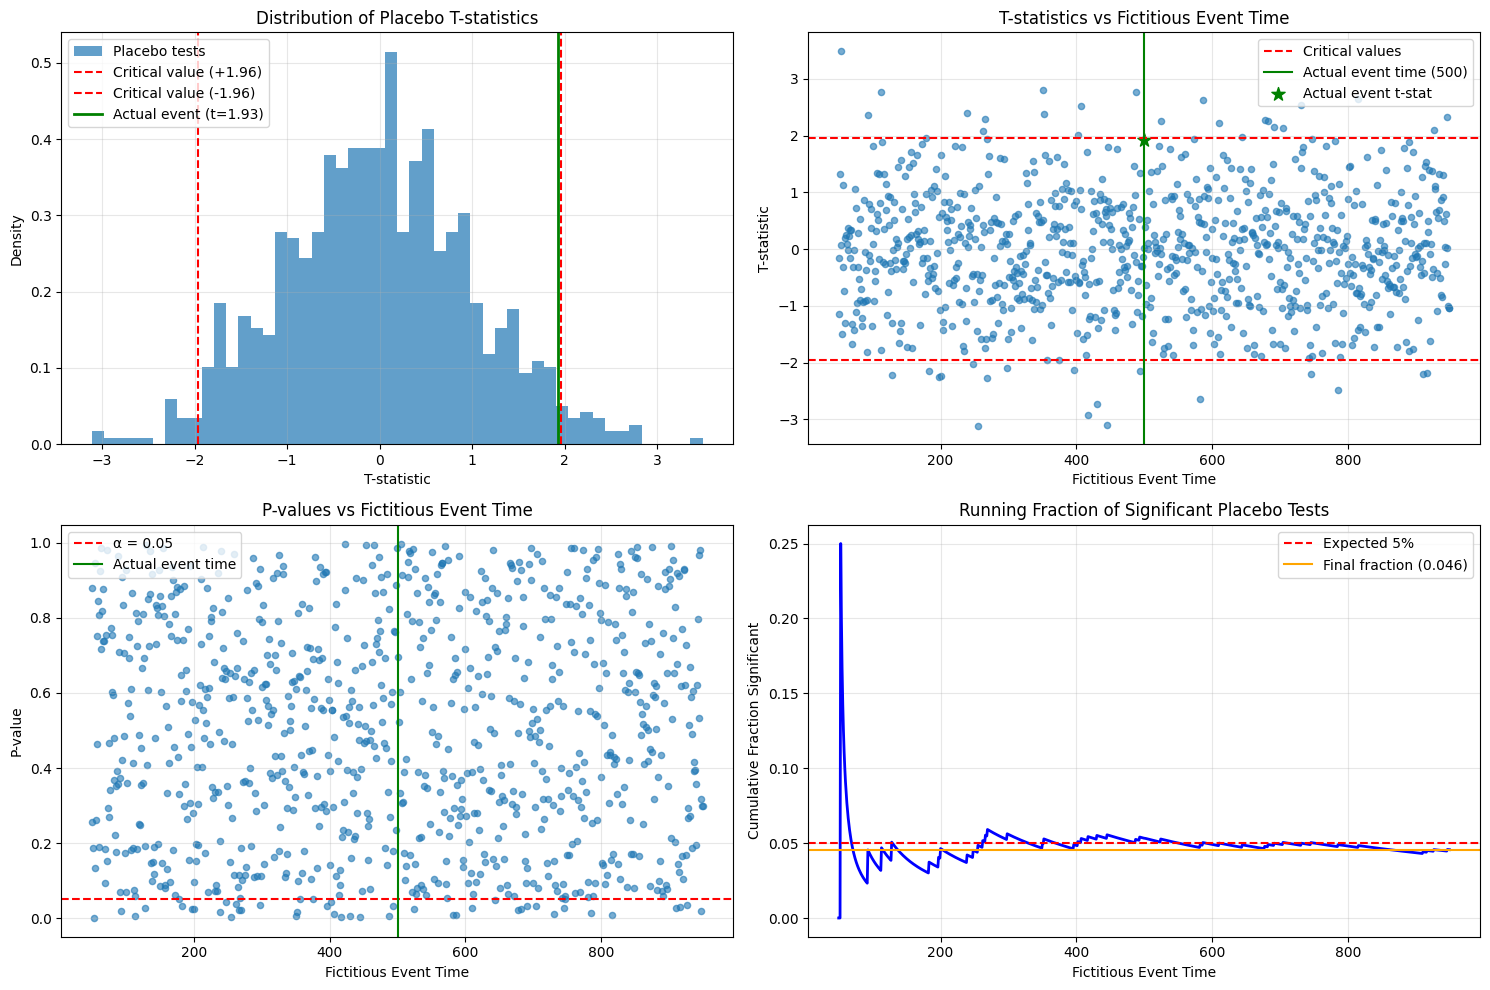


Summary statistics for placebo tests:
Mean t-statistic: -0.0214
Std t-statistic: 1.0205
Min t-statistic: -3.1100
Max t-statistic: 3.4887


In [45]:
n_simulations = 1000
store = []
significant = 0

# Fixed parameters
num = 1000
actual_event_time = int(num / 2)  # Event is always at time 500

# Generate the fixed dataset once
np.random.seed(0)
R_market = np.random.normal(0, 1, num) + np.arange(num) / num 
R_target = 2 + R_market + np.random.normal(0, 1, num) + (np.arange(num) == actual_event_time + 1) * 2 

# Perform placebo tests at all possible times
placebo_results = []
total_placebo_tests = 0
significant_placebo = 0

for fictitious_event_time in range(50, num - 50):  # Avoid edges to ensure enough data
    if fictitious_event_time == actual_event_time:
        continue  # Skip the actual event time
    
    # Fit model on pre-fictitious-event data
    try:
        results = sm.OLS(R_target[:fictitious_event_time], 
                        sm.add_constant(R_market[:fictitious_event_time])).fit() 
        alpha, beta = results.params 
        resid = R_target - results.predict(sm.add_constant(R_market)) 

        # Calculate t-statistic for fictitious event at fictitious_event_time + 1
        if fictitious_event_time + 1 < num:
            t_stat = resid[fictitious_event_time + 1] / resid[:fictitious_event_time].std(ddof=2)
            p_value = 2 * (1 - stats.norm.cdf(np.abs(t_stat)))

            placebo_results.append({
                'fictitious_event_time': fictitious_event_time,
                't_stat': t_stat,
                'p_value': p_value,
                'significant': abs(t_stat) > 1.96
            })

            total_placebo_tests += 1
            if abs(t_stat) > 1.96:
                significant_placebo += 1
    except:
        continue  # Skip if regression fails

# Calculate fraction of significant placebo tests
fraction_significant_placebo = significant_placebo / total_placebo_tests if total_placebo_tests > 0 else 0

print(f"Total placebo tests performed: {total_placebo_tests}")
print(f"Significant placebo tests: {significant_placebo}")
print(f"Fraction of placebo tests detecting an event: {fraction_significant_placebo:.4f}")
print(f"Percentage: {fraction_significant_placebo * 100:.2f}%")

# Now test detection at the actual event time
results_actual = sm.OLS(R_target[:actual_event_time], 
                       sm.add_constant(R_market[:actual_event_time])).fit() 
resid_actual = R_target - results_actual.predict(sm.add_constant(R_market)) 
t_stat_actual = resid_actual[actual_event_time + 1] / resid_actual[:actual_event_time].std(ddof=2)

print(f"\nActual event detection:")
print(f"T-statistic at actual event time: {t_stat_actual:.4f}")
print(f"Significant at actual event time: {abs(t_stat_actual) > 1.96}")

# Visualize the results
plt.figure(figsize=(15, 10))

# Plot 1: Distribution of placebo t-statistics
plt.subplot(2, 2, 1)
placebo_t_stats = [result['t_stat'] for result in placebo_results]
plt.hist(placebo_t_stats, bins=50, alpha=0.7, density=True, label='Placebo tests')
plt.axvline(x=1.96, color='red', linestyle='--', label='Critical value (+1.96)')
plt.axvline(x=-1.96, color='red', linestyle='--', label='Critical value (-1.96)')
plt.axvline(x=t_stat_actual, color='green', linestyle='-', linewidth=2, label=f'Actual event (t={t_stat_actual:.2f})')
plt.xlabel('T-statistic')
plt.ylabel('Density')
plt.title('Distribution of Placebo T-statistics')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: T-statistics over time
plt.subplot(2, 2, 2)
fictitious_times = [result['fictitious_event_time'] for result in placebo_results]
plt.scatter(fictitious_times, placebo_t_stats, alpha=0.6, s=20)
plt.axhline(y=1.96, color='red', linestyle='--', label='Critical values')
plt.axhline(y=-1.96, color='red', linestyle='--')
plt.axvline(x=actual_event_time, color='green', linestyle='-', label=f'Actual event time ({actual_event_time})')
plt.scatter([actual_event_time], [t_stat_actual], color='green', s=100, marker='*', label='Actual event t-stat')
plt.xlabel('Fictitious Event Time')
plt.ylabel('T-statistic')
plt.title('T-statistics vs Fictitious Event Time')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 3: P-values over time
plt.subplot(2, 2, 3)
p_values = [result['p_value'] for result in placebo_results]
plt.scatter(fictitious_times, p_values, alpha=0.6, s=20)
plt.axhline(y=0.05, color='red', linestyle='--', label='α = 0.05')
plt.axvline(x=actual_event_time, color='green', linestyle='-', label=f'Actual event time')
plt.xlabel('Fictitious Event Time')
plt.ylabel('P-value')
plt.title('P-values vs Fictitious Event Time')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 4: Cumulative significant tests
plt.subplot(2, 2, 4)
significant_flags = [result['significant'] for result in placebo_results]
cumulative_significant = np.cumsum(significant_flags)
cumulative_fraction = cumulative_significant / np.arange(1, len(significant_flags) + 1)
plt.plot(fictitious_times, cumulative_fraction, 'b-', linewidth=2)
plt.axhline(y=0.05, color='red', linestyle='--', label='Expected 5%')
plt.axhline(y=fraction_significant_placebo, color='orange', linestyle='-', label=f'Final fraction ({fraction_significant_placebo:.3f})')
plt.xlabel('Fictitious Event Time')
plt.ylabel('Cumulative Fraction Significant')
plt.title('Running Fraction of Significant Placebo Tests')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nSummary statistics for placebo tests:")
print(f"Mean t-statistic: {np.mean(placebo_t_stats):.4f}")
print(f"Std t-statistic: {np.std(placebo_t_stats):.4f}")
print(f"Min t-statistic: {np.min(placebo_t_stats):.4f}")
print(f"Max t-statistic: {np.max(placebo_t_stats):.4f}")

Number of runs completed: 80
Average fraction of placebo tests with higher t-statistics: 0.1359
Percentage: 13.59%
Standard deviation: 0.1859


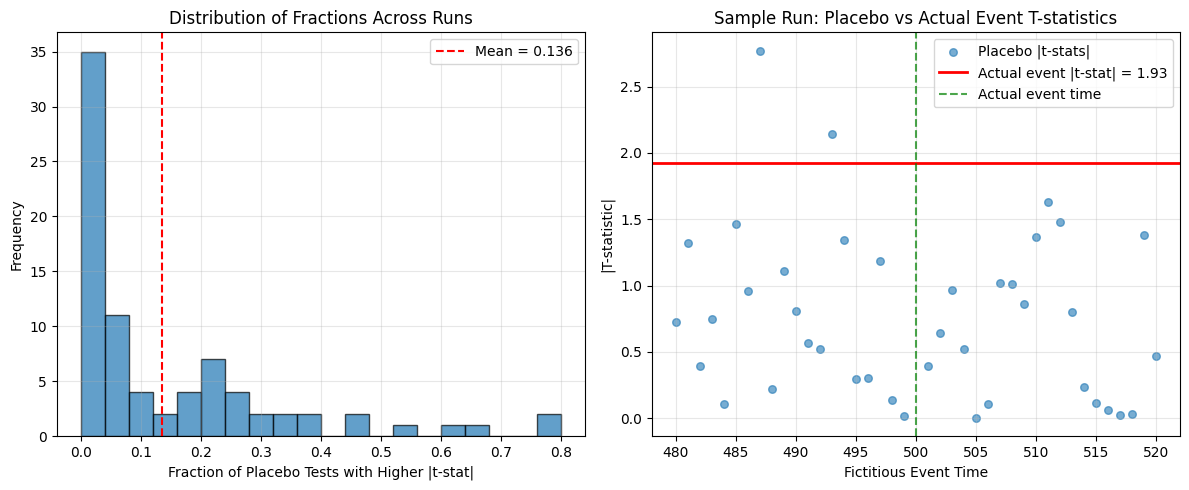


Sample run details (seed=0):
Actual event t-statistic: 1.9268
Number of placebo tests: 40
Placebo tests with higher |t-stat|: 2
Fraction for this sample: 0.0500


In [47]:
n_runs = 80  # Number of different datasets to test
fraction_higher_list = []

for run in range(n_runs):
    # Set different seed for each run to get different datasets
    np.random.seed(run)
    
    # Fixed parameters
    num = 1000
    actual_event_time = int(num / 2)  # Event is always at time 500
    
    # Generate dataset for this run
    R_market = np.random.normal(0, 1, num) + np.arange(num) / num 
    R_target = 2 + R_market + np.random.normal(0, 1, num) + (np.arange(num) == actual_event_time + 1) * 2 
    
    # First, get the actual event t-statistic
    results_actual = sm.OLS(R_target[:actual_event_time], 
                           sm.add_constant(R_market[:actual_event_time])).fit() 
    resid_actual = R_target - results_actual.predict(sm.add_constant(R_market)) 
    t_stat_actual = resid_actual[actual_event_time + 1] / resid_actual[:actual_event_time].std(ddof=2)
    
    # Perform placebo tests: 20 before and 20 after the actual event
    placebo_t_stats = []
    
    # 20 tests before the actual event
    before_times = range(actual_event_time - 20, actual_event_time)
    for fictitious_event_time in before_times:
        if fictitious_event_time > 50:  # Ensure enough data for regression
            try:
                results = sm.OLS(R_target[:fictitious_event_time], 
                                sm.add_constant(R_market[:fictitious_event_time])).fit() 
                resid = R_target - results.predict(sm.add_constant(R_market)) 
                t_stat = resid[fictitious_event_time + 1] / resid[:fictitious_event_time].std(ddof=2)
                placebo_t_stats.append(t_stat)
            except:
                continue
    
    # 20 tests after the actual event
    after_times = range(actual_event_time + 1, actual_event_time + 21)
    for fictitious_event_time in after_times:
        if fictitious_event_time < num - 50:  # Ensure enough data
            try:
                results = sm.OLS(R_target[:fictitious_event_time], 
                                sm.add_constant(R_market[:fictitious_event_time])).fit() 
                resid = R_target - results.predict(sm.add_constant(R_market)) 
                t_stat = resid[fictitious_event_time + 1] / resid[:fictitious_event_time].std(ddof=2)
                placebo_t_stats.append(t_stat)
            except:
                continue
    
    # Count how many placebo tests have higher t-statistics than the actual event
    if len(placebo_t_stats) > 0:
        higher_count = sum(1 for t_stat in placebo_t_stats if abs(t_stat) > abs(t_stat_actual))
        fraction_higher = higher_count / len(placebo_t_stats)
        fraction_higher_list.append(fraction_higher)

# Calculate average fraction across all runs
average_fraction_higher = np.mean(fraction_higher_list)

print(f"Number of runs completed: {len(fraction_higher_list)}")
print(f"Average fraction of placebo tests with higher t-statistics: {average_fraction_higher:.4f}")
print(f"Percentage: {average_fraction_higher * 100:.2f}%")
print(f"Standard deviation: {np.std(fraction_higher_list):.4f}")

# Show distribution of fractions
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(fraction_higher_list, bins=20, alpha=0.7, edgecolor='black')
plt.xlabel('Fraction of Placebo Tests with Higher |t-stat|')
plt.ylabel('Frequency')
plt.title('Distribution of Fractions Across Runs')
plt.axvline(x=average_fraction_higher, color='red', linestyle='--', 
           label=f'Mean = {average_fraction_higher:.3f}')
plt.legend()
plt.grid(True, alpha=0.3)

# Show a sample run for illustration
np.random.seed(0)  # Use seed 0 for consistent example
R_market_sample = np.random.normal(0, 1, num) + np.arange(num) / num 
R_target_sample = 2 + R_market_sample + np.random.normal(0, 1, num) + (np.arange(num) == actual_event_time + 1) * 2 

# Get actual event t-stat for sample
results_sample = sm.OLS(R_target_sample[:actual_event_time], 
                       sm.add_constant(R_market_sample[:actual_event_time])).fit() 
resid_sample = R_target_sample - results_sample.predict(sm.add_constant(R_market_sample)) 
t_stat_sample = resid_sample[actual_event_time + 1] / resid_sample[:actual_event_time].std(ddof=2)

# Get placebo t-stats for sample
sample_placebo_t_stats = []
sample_times = []

for fictitious_event_time in list(range(actual_event_time - 20, actual_event_time)) + list(range(actual_event_time + 1, actual_event_time + 21)):
    if 50 < fictitious_event_time < num - 50:
        try:
            results = sm.OLS(R_target_sample[:fictitious_event_time], 
                            sm.add_constant(R_market_sample[:fictitious_event_time])).fit() 
            resid = R_target_sample - results.predict(sm.add_constant(R_market_sample)) 
            t_stat = resid[fictitious_event_time + 1] / resid[:fictitious_event_time].std(ddof=2)
            sample_placebo_t_stats.append(t_stat)
            sample_times.append(fictitious_event_time)
        except:
            continue

plt.subplot(1, 2, 2)
plt.scatter(sample_times, [abs(t) for t in sample_placebo_t_stats], alpha=0.6, s=30, label='Placebo |t-stats|')
plt.axhline(y=abs(t_stat_sample), color='red', linestyle='-', linewidth=2, 
           label=f'Actual event |t-stat| = {abs(t_stat_sample):.2f}')
plt.axvline(x=actual_event_time, color='green', linestyle='--', alpha=0.7, label='Actual event time')
plt.xlabel('Fictitious Event Time')
plt.ylabel('|T-statistic|')
plt.title('Sample Run: Placebo vs Actual Event T-statistics')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nSample run details (seed=0):")
print(f"Actual event t-statistic: {t_stat_sample:.4f}")
print(f"Number of placebo tests: {len(sample_placebo_t_stats)}")
higher_sample = sum(1 for t in sample_placebo_t_stats if abs(t) > abs(t_stat_sample))
print(f"Placebo tests with higher |t-stat|: {higher_sample}")
print(f"Fraction for this sample: {higher_sample/len(sample_placebo_t_stats):.4f}")

In [48]:
def make_error(corr_const, num): 
    sigma = 5 * 1 / np.sqrt((1 - corr_const)**2 / (1 - corr_const**2)) 
    err = list() 
    prev = np.random.normal(0, sigma) 
    for n in range(num): 
        prev = corr_const * prev + (1 - corr_const) * np.random.normal(0, sigma) 
        err.append(prev) 
 
    return np.array(err) 

RESULTS WITH CORRELATED ERRORS (corr_const = 0.9):
Number of runs completed: 1000
Average fraction of placebo tests with higher t-statistics: 0.4774
Percentage: 47.74%
Standard deviation: 0.3143

COMPARISON:
Independent errors (previous): 0.1359 (13.59%)
Correlated errors (current): 0.4774 (47.74%)
Difference: 0.3415
➜ Correlated errors result in MORE false positives (as expected)


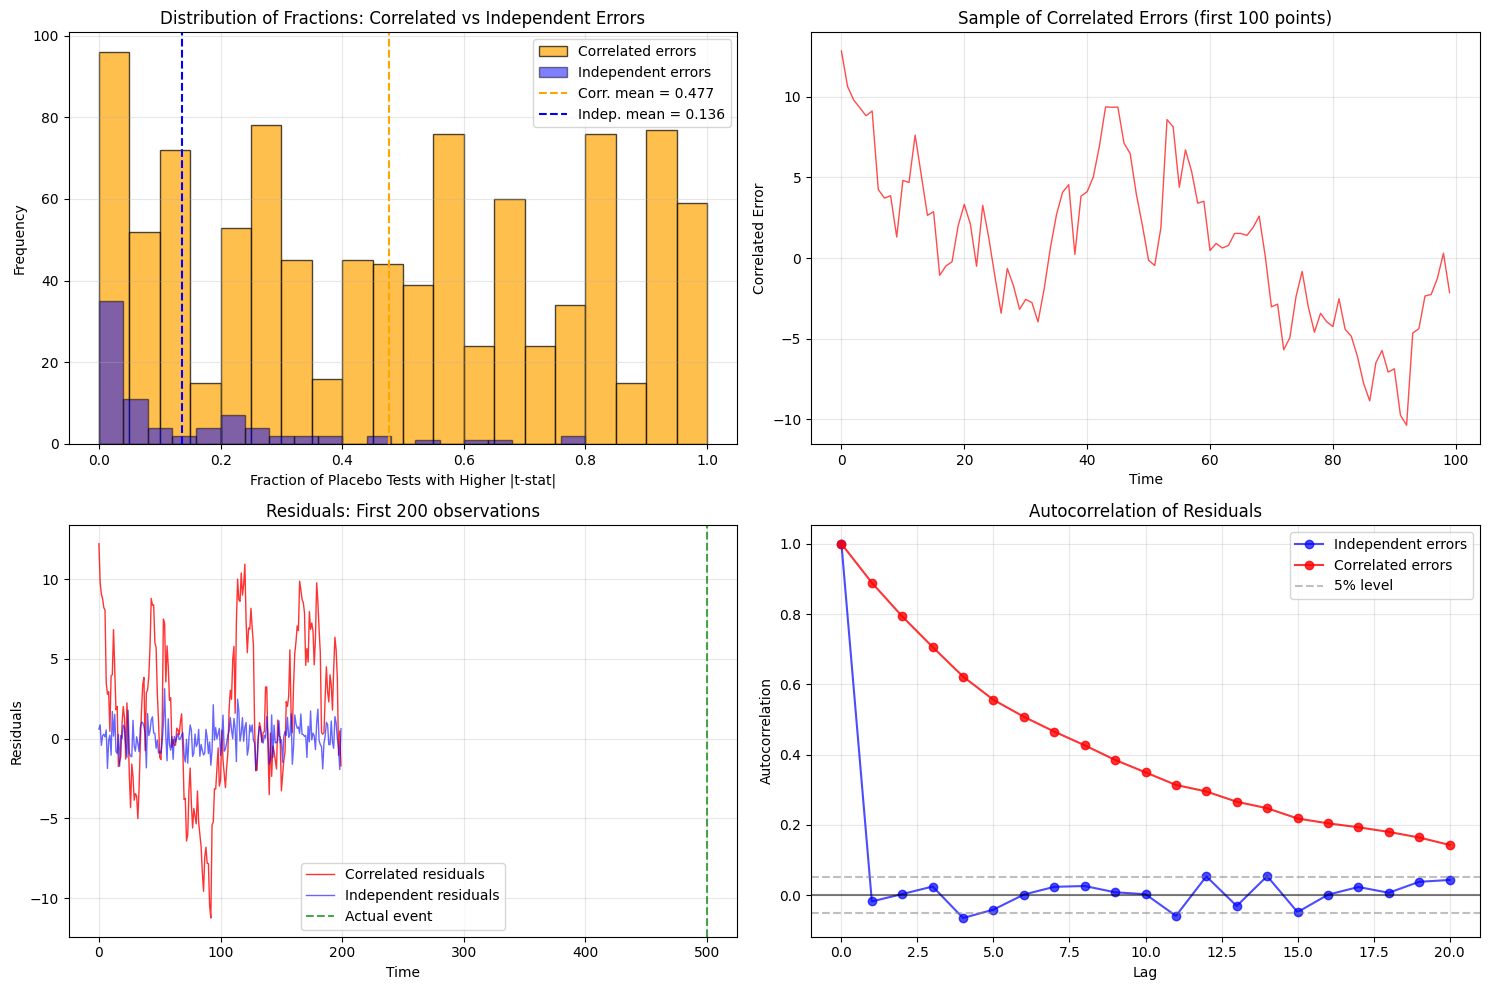


STATISTICAL TEST:
T-test for difference in means:
T-statistic: 9.5765
P-value: 0.0000
➜ Statistically significant difference at 5% level


In [52]:
# Question with correlated errors
n_runs = 42  # Number of different datasets to test
fraction_higher_list_corr = []
n_simulations = 1000

for run in range(n_simulations):
    # Set different seed for each run to get different datasets
    np.random.seed(run)
    
    # Fixed parameters
    num = 1000
    actual_event_time = int(num / 2)  # Event is always at time 500
    
    # Generate dataset for this run with correlated errors
    R_market = np.random.normal(0, 1, num) + np.arange(num) / num 
    
    # Use make_error with corr_const = 0.9 instead of np.random.normal
    correlated_errors = make_error(corr_const=0.9, num=num)
    R_target = 2 + R_market + correlated_errors + (np.arange(num) == actual_event_time + 1) * 2 
    
    # First, get the actual event t-statistic
    results_actual = sm.OLS(R_target[:actual_event_time], 
                           sm.add_constant(R_market[:actual_event_time])).fit() 
    resid_actual = R_target - results_actual.predict(sm.add_constant(R_market)) 
    t_stat_actual = resid_actual[actual_event_time + 1] / resid_actual[:actual_event_time].std(ddof=2)
    
    # Perform placebo tests: 20 before and 20 after the actual event
    placebo_t_stats = []
    
    # 20 tests before the actual event
    before_times = range(actual_event_time - 20, actual_event_time)
    for fictitious_event_time in before_times:
        if fictitious_event_time > 50:  # Ensure enough data for regression
            try:
                results = sm.OLS(R_target[:fictitious_event_time], 
                                sm.add_constant(R_market[:fictitious_event_time])).fit() 
                resid = R_target - results.predict(sm.add_constant(R_market)) 
                t_stat = resid[fictitious_event_time + 1] / resid[:fictitious_event_time].std(ddof=2)
                placebo_t_stats.append(t_stat)
            except:
                continue
    
    # 20 tests after the actual event
    after_times = range(actual_event_time + 1, actual_event_time + 21)
    for fictitious_event_time in after_times:
        if fictitious_event_time < num - 50:  # Ensure enough data
            try:
                results = sm.OLS(R_target[:fictitious_event_time], 
                                sm.add_constant(R_market[:fictitious_event_time])).fit() 
                resid = R_target - results.predict(sm.add_constant(R_market)) 
                t_stat = resid[fictitious_event_time + 1] / resid[:fictitious_event_time].std(ddof=2)
                placebo_t_stats.append(t_stat)
            except:
                continue
    
    # Count how many placebo tests have higher t-statistics than the actual event
    if len(placebo_t_stats) > 0:
        higher_count = sum(1 for t_stat in placebo_t_stats if abs(t_stat) > abs(t_stat_actual))
        fraction_higher = higher_count / len(placebo_t_stats)
        fraction_higher_list_corr.append(fraction_higher)

# Calculate average fraction across all runs
average_fraction_higher_corr = np.mean(fraction_higher_list_corr)

print(f"RESULTS WITH CORRELATED ERRORS (corr_const = 0.9):")
print(f"Number of runs completed: {len(fraction_higher_list_corr)}")
print(f"Average fraction of placebo tests with higher t-statistics: {average_fraction_higher_corr:.4f}")
print(f"Percentage: {average_fraction_higher_corr * 100:.2f}%")
print(f"Standard deviation: {np.std(fraction_higher_list_corr):.4f}")

# Compare with previous results (if available)
if 'average_fraction_higher' in locals():
    print(f"\nCOMPARISON:")
    print(f"Independent errors (previous): {average_fraction_higher:.4f} ({average_fraction_higher * 100:.2f}%)")
    print(f"Correlated errors (current): {average_fraction_higher_corr:.4f} ({average_fraction_higher_corr * 100:.2f}%)")
    print(f"Difference: {(average_fraction_higher_corr - average_fraction_higher):.4f}")
    if average_fraction_higher_corr > average_fraction_higher:
        print("➜ Correlated errors result in MORE false positives (as expected)")
    else:
        print("➜ Correlated errors result in FEWER false positives (unexpected)")

# Visualize comparison
plt.figure(figsize=(15, 10))

# Plot 1: Distribution comparison
plt.subplot(2, 2, 1)
plt.hist(fraction_higher_list_corr, bins=20, alpha=0.7, label='Correlated errors', color='orange', edgecolor='black')
if 'fraction_higher_list' in locals():
    plt.hist(fraction_higher_list, bins=20, alpha=0.5, label='Independent errors', color='blue', edgecolor='black')
plt.xlabel('Fraction of Placebo Tests with Higher |t-stat|')
plt.ylabel('Frequency')
plt.title('Distribution of Fractions: Correlated vs Independent Errors')
plt.axvline(x=average_fraction_higher_corr, color='orange', linestyle='--', 
           label=f'Corr. mean = {average_fraction_higher_corr:.3f}')
if 'average_fraction_higher' in locals():
    plt.axvline(x=average_fraction_higher, color='blue', linestyle='--', 
               label=f'Indep. mean = {average_fraction_higher:.3f}')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Sample run with correlated errors
plt.subplot(2, 2, 2)
np.random.seed(0)  # Use seed 0 for consistent example
R_market_sample = np.random.normal(0, 1, num) + np.arange(num) / num 
corr_errors_sample = make_error(corr_const=0.9, num=num)
R_target_sample_corr = 2 + R_market_sample + corr_errors_sample + (np.arange(num) == actual_event_time + 1) * 2 

# Show the correlated errors
plt.plot(corr_errors_sample[:100], 'r-', alpha=0.7, linewidth=1)
plt.xlabel('Time')
plt.ylabel('Correlated Error')
plt.title('Sample of Correlated Errors (first 100 points)')
plt.grid(True, alpha=0.3)

# Plot 3: Residuals comparison
plt.subplot(2, 2, 3)
results_sample_corr = sm.OLS(R_target_sample_corr[:actual_event_time], 
                            sm.add_constant(R_market_sample[:actual_event_time])).fit() 
resid_sample_corr = R_target_sample_corr - results_sample_corr.predict(sm.add_constant(R_market_sample))

plt.plot(resid_sample_corr[:200], 'r-', alpha=0.8, linewidth=1, label='Correlated residuals')
if 'resid_sample' in locals():
    plt.plot(resid_sample[:200], 'b-', alpha=0.6, linewidth=1, label='Independent residuals')
plt.axvline(x=actual_event_time, color='green', linestyle='--', alpha=0.7, label='Actual event')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.title('Residuals: First 200 observations')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 4: Autocorrelation of residuals
plt.subplot(2, 2, 4)
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import acf

# Calculate autocorrelation
resid_corr_acf = acf(resid_sample_corr[:actual_event_time], nlags=20)
if 'resid_sample' in locals():
    resid_indep_acf = acf(resid_sample[:actual_event_time], nlags=20)
    plt.plot(range(21), resid_indep_acf, 'b-o', alpha=0.7, label='Independent errors')

plt.plot(range(21), resid_corr_acf, 'r-o', alpha=0.8, label='Correlated errors')
plt.axhline(y=0, color='black', linestyle='-', alpha=0.5)
plt.axhline(y=0.05, color='gray', linestyle='--', alpha=0.5, label='5% level')
plt.axhline(y=-0.05, color='gray', linestyle='--', alpha=0.5)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation of Residuals')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Statistical test for difference
if 'fraction_higher_list' in locals() and len(fraction_higher_list) > 0:
    from scipy.stats import ttest_ind
    t_stat, p_value = ttest_ind(fraction_higher_list_corr, fraction_higher_list)
    print(f"\nSTATISTICAL TEST:")
    print(f"T-test for difference in means:")
    print(f"T-statistic: {t_stat:.4f}")
    print(f"P-value: {p_value:.4f}")
    if p_value < 0.05:
        print("➜ Statistically significant difference at 5% level")
    else:
        print("➜ No statistically significant difference at 5% level")